## Matthew Hurricane Disaster Images ##

### Looking at the heatmap, the model does not perform as well on 0s as on 1s considering on the diagonal, the 0s is darker. On the error plot, the column for class 1 is quite bright, which tells that many images get missclassified as 1s. The model performs less when only the last layer is fine-tuned with test set accuracy of 73.109% compared to 76.471% when more layers are fine-tuned. ###

### The dataset size is not a representative of how well the model performs. The highest test-set accuracies are not necessarily the largest dataset size ###

In [72]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [73]:
import tensorflow as tf

tf.test.gpu_device_name()

''

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [75]:
import os

In [76]:
from sklearn.metrics import confusion_matrix

## Load data ##

In [77]:
train_dir = 'data_matthew_hurricane/train'
validation_dir = 'data_matthew_hurricane/validation'
test_dir = 'data_matthew_hurricane/test'

In [78]:
train_damaged_dir = os.path.join(train_dir, 'damaged')  # directory with our training damaged pictures
train_undamaged_dir = os.path.join(train_dir, 'undamaged')  # directory with our training undamaged pictures
validation_damaged_dir = os.path.join(validation_dir, 'damaged')  # directory with our validation damaged pictures
validation_undamaged_dir = os.path.join(validation_dir, 'undamaged')  # directory with our validation undamaged pictures
test_damaged_dir = os.path.join(test_dir, 'damaged')  # directory with our test damaged pictures
test_undamaged_dir = os.path.join(test_dir, 'undamaged')  # directory with our test undamaged pictures


## Understand the data ##

### Let's look at how many damaged and undamaged images are in the training and validation directory: ###

In [79]:
num_damaged_tr = len(os.listdir(train_damaged_dir))
num_undamaged_tr = len(os.listdir(train_undamaged_dir))

num_damaged_val = len(os.listdir(validation_damaged_dir))
num_undamaged_val = len(os.listdir(validation_undamaged_dir))

num_damaged_ts = len(os.listdir(test_damaged_dir))
num_undamaged_ts = len(os.listdir(test_undamaged_dir))

total_train = num_damaged_tr + num_undamaged_tr
total_val = num_damaged_val + num_undamaged_val
total_test = num_damaged_ts + num_undamaged_ts

In [80]:
print('total training damaged images:', num_damaged_tr)
print('total training undamaged images:', num_undamaged_tr)

print('total validation damaged images:', num_damaged_val)
print('total validation undamaged images:', num_undamaged_val)

print('total test damaged images:', num_damaged_ts)
print('total test undamaged images:', num_undamaged_ts)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_test)

total training damaged images: 162
total training undamaged images: 195
total validation damaged images: 54
total validation undamaged images: 66
total test damaged images: 54
total test undamaged images: 65
--
Total training images: 357
Total validation images: 120
Total test images: 119


In [81]:
# set up variables
#batch_size = 128


batch_size = 8
#epochs = 5
#IMG_HEIGHT = 150
#IMG_WIDTH = 150

# VGG19, VGG16, Inception
#IMG_HEIGHT = 224
#IMG_WIDTH = 224

# inceptionV3
#IMG_HEIGHT = 299
#IMG_WIDTH = 299


IMG_HEIGHT = 331
IMG_WIDTH = 331

## Data preparation ##

In [82]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

In [83]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 357 images belonging to 2 classes.


In [84]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 120 images belonging to 2 classes.


In [85]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 119 images belonging to 2 classes.


## Visualize training images ##

In [18]:
sample_training_images, _ = next(train_data_gen)

In [19]:
sample_training_images, labels = next(train_data_gen)

In [20]:
labels

array([1., 0., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [21]:
sample_training_images, labels = next(train_data_gen)

In [22]:
labels

array([1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)

In [23]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

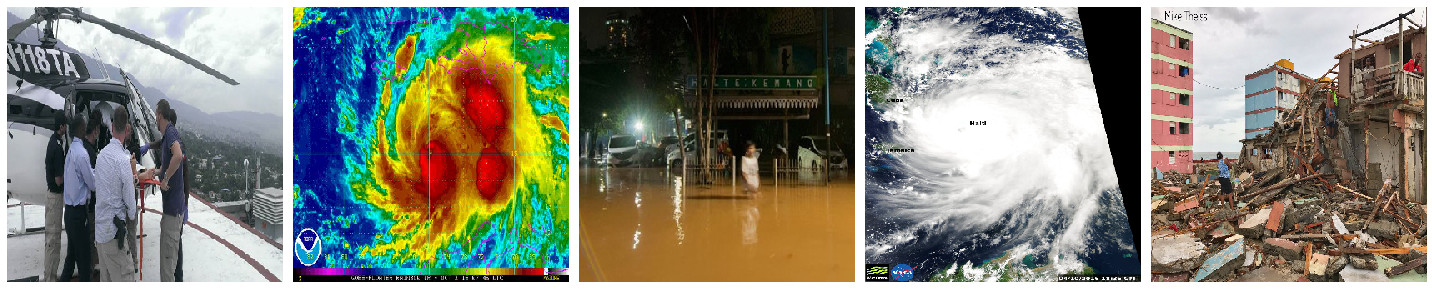

In [24]:
plotImages(sample_training_images[:5])

In [31]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(40,40))
  for n in range(7):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      #plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.title(label_batch[n], fontdict={'fontsize':28})
      plt.axis('off')

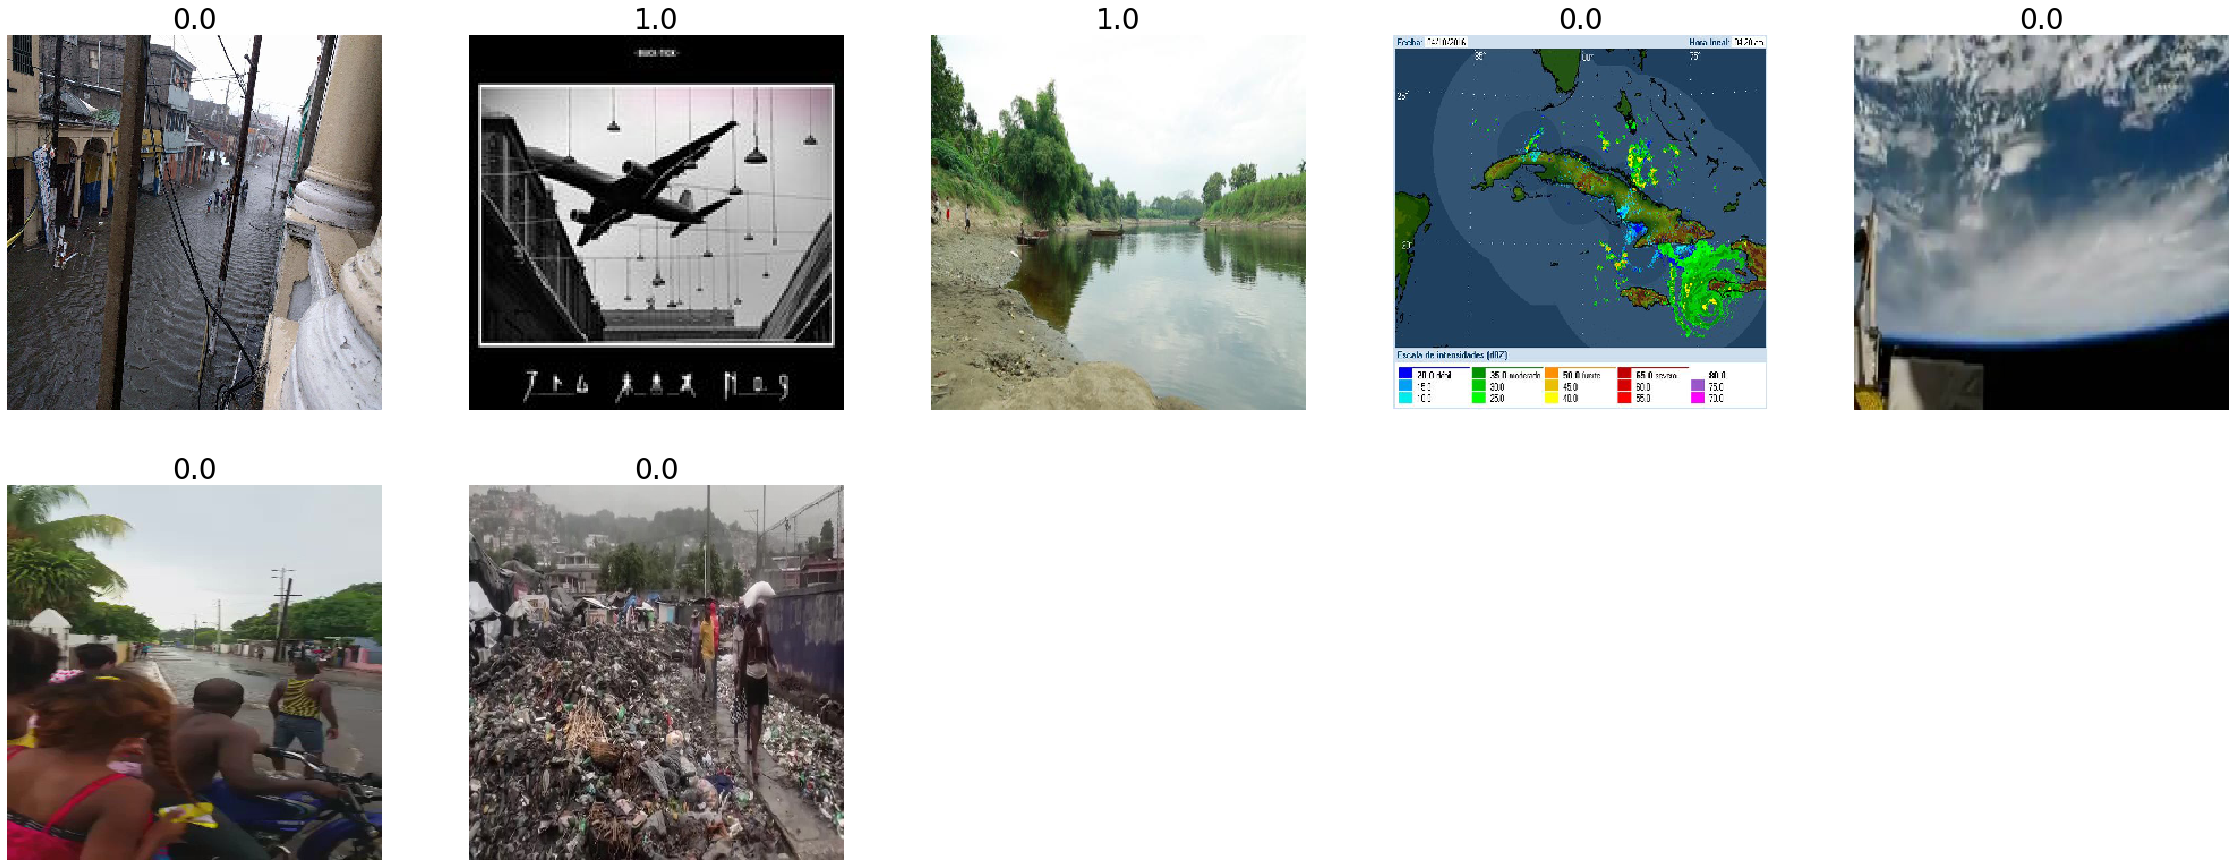

In [32]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [33]:
#train_data_gen.classes[:50]

In [34]:
label_batch

array([0., 1., 1., 0., 0., 0., 0., 0.], dtype=float32)

## NASNetLarge Pre-trained model ##

In [40]:
from keras.applications.nasnet import NASNetLarge
from keras.preprocessing import image
from keras.applications.nasnet import preprocess_input

In [41]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

In [42]:
from keras import optimizers

In [43]:
from keras.callbacks import EarlyStopping

In [44]:
#callback = EarlyStopping(monitor='val_loss', patience=7)

callback = EarlyStopping(monitor='val_acc', patience=7, restore_best_weights=True)

In [45]:
base_model = NASNetLarge(weights='imagenet', include_top=False)

W1127 15:03:26.254996 140257391912768 deprecation_wrapper.py:119] From /home/demolakstate/anaconda3/envs/dl/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1127 15:03:26.256468 140257391912768 deprecation_wrapper.py:119] From /home/demolakstate/anaconda3/envs/dl/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1127 15:03:26.270941 140257391912768 deprecation_wrapper.py:119] From /home/demolakstate/anaconda3/envs/dl/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1127 15:03:26.298656 140257391912768 deprecation_wrapper.py:119] From /home/demolakstate/anaconda3/envs/dl/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_de

In [44]:
rmsprop = optimizers.RMSprop(lr=0.00001, rho=0.9)

In [52]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model_NasNet = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#model_NasNet.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



model_NasNet.compile(optimizer=rmsprop, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

NameError: name 'rmsprop' is not defined

In [46]:
history_NasNet = model_NasNet.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=30,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    #callbacks=[callback, cp_callback]
    callbacks=[callback]
)

Epoch 1/30
2/2 [==============================] - 117s 58s/step - loss: 0.7058 - acc: 0.5050 - val_loss: 0.6840 - val_acc: 0.5333
Epoch 2/30
2/2 [==============================] - 117s 59s/step - loss: 0.6640 - acc: 0.5820 - val_loss: 0.6765 - val_acc: 0.5667
Epoch 3/30
2/2 [==============================] - 115s 57s/step - loss: 0.6565 - acc: 0.6292 - val_loss: 0.6694 - val_acc: 0.5750
Epoch 4/30
2/2 [==============================] - 109s 55s/step - loss: 0.6274 - acc: 0.6895 - val_loss: 0.6560 - val_acc: 0.5833
Epoch 5/30
2/2 [==============================] - 126s 63s/step - loss: 0.6152 - acc: 0.7031 - val_loss: 0.6571 - val_acc: 0.6083
Epoch 6/30
2/2 [==============================] - 117s 58s/step - loss: 0.6051 - acc: 0.7492 - val_loss: 0.6418 - val_acc: 0.5750
Epoch 7/30
2/2 [==============================] - 110s 55s/step - loss: 0.5934 - acc: 0.7104 - val_loss: 0.6372 - val_acc: 0.6167
Epoch 8/30
2/2 [==============================] - 113s 56s/step - loss: 0.5769 - acc: 0.78

In [35]:
# Save the entire model to a HDF5 file
#model_NasNet.save('data_matthew_hurricane/NasNet_model_matthew.h5')


In [90]:
#model_NasNet.load_weights('data_matthew_hurricane/NasNet_model_matthew.h5')


model_NasNet = tf.keras.models.load_model('data_matthew_hurricane/NasNet_model_matthew.h5')

W1201 22:09:15.986403 140257391912768 deprecation.py:573] From /home/demolakstate/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py:507: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with distribution=normal is deprecated and will be removed in a future version.
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
W1201 22:09:16.024657 140257391912768 deprecation.py:506] From /home/demolakstate/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Visualize NasNetLarge model ##

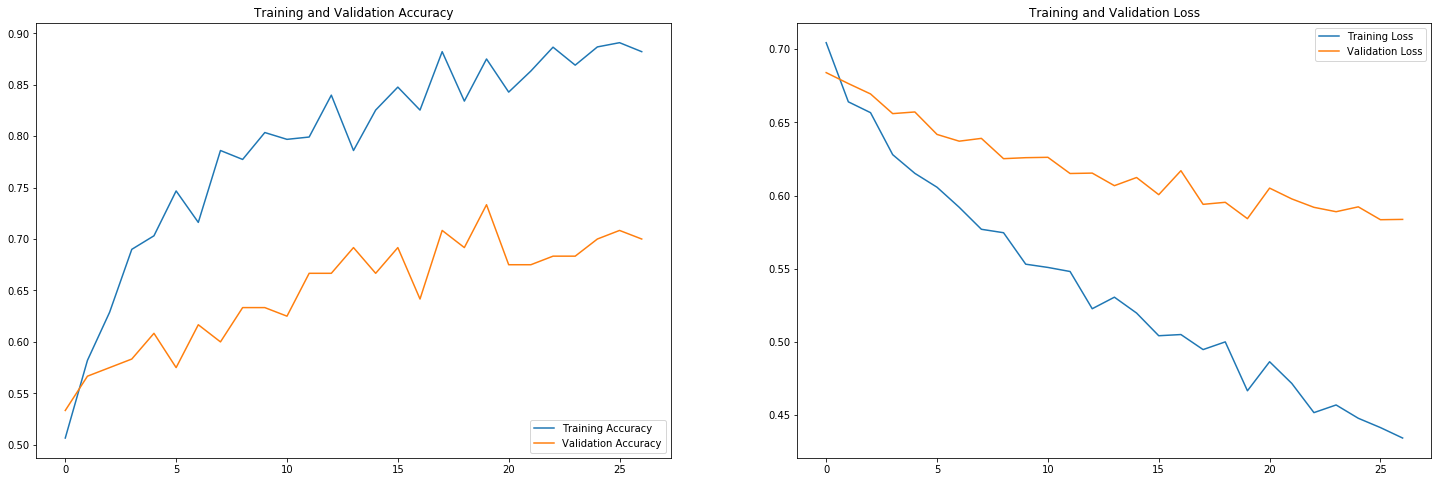

In [48]:
acc = history_NasNet.history['acc']
val_acc = history_NasNet.history['val_acc']

loss = history_NasNet.history['loss']
val_loss = history_NasNet.history['val_loss']

epochs_range = range(27)

plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation of NasNet model accuracy on test data ##

### Let's compare how the model performs on the test dataset ###

In [49]:
test_loss, test_acc = model_NasNet.evaluate_generator(test_data_gen, verbose=0)

In [50]:
print('\nTest accuracy:', test_acc)


Test accuracy: 0.7310924530029297


In [51]:
print('\nTest loss:', test_loss)


Test loss: 0.5553790926933289


## Make predictions on test data ##

### Let's make predictions on some images ###

In [93]:
test_data_gen.class_indices

{'damaged': 0, 'undamaged': 1}

In [94]:
predictions = model_NasNet.predict_generator(test_data_gen)

In [95]:
true_labels = test_data_gen.classes

In [96]:
predictions[0]

array([0.07792758, 0.9220724 ], dtype=float32)

In [97]:
np.argmax(predictions[0])

1

In [98]:
test_data_gen.classes[0]

0

In [99]:
predictions[-1]

array([0.5423339 , 0.45766613], dtype=float32)

In [100]:
np.argmax(predictions[-1])

0

In [101]:
test_data_gen.classes[-1]

1

In [102]:
test_data_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

## Confusion Matrix ##

In [103]:
import matplotlib.pyplot as plt
import numpy as np

In [104]:
y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

In [105]:
y_pred

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0])

In [106]:
cm = confusion_matrix(y_true, y_pred)

In [107]:
print(cm)

[[16 38]
 [27 38]]


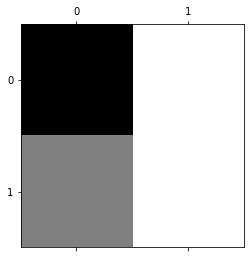

In [108]:
plt.matshow(cm, cmap=plt.cm.gray)
plt.show()

## Plot on Errors ##

In [109]:
row_sums = cm.sum(axis=1, keepdims=True)
norm_cm = cm / row_sums

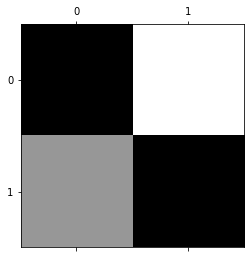

In [110]:
np.fill_diagonal(norm_cm, 0)
plt.matshow(norm_cm, cmap=plt.cm.gray)
plt.show()

## Confusion Matrix Heat Map ##

In [583]:
#!pip install seaborn

In [584]:
#import seaborn as sb

In [585]:
#heat_map = sb.heatmap(cm, annot=True)
#sb.set(font_scale=1)
#plt.show()

## Classification report of NasNet on test set ##

In [586]:
from sklearn.metrics import classification_report

In [587]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62       274
           1       0.42      0.41      0.41       182

    accuracy                           0.54       456
   macro avg       0.52      0.52      0.52       456
weighted avg       0.54      0.54      0.54       456



## Fine-tuning more layers in NASNetLarge ##

In [46]:
from keras.callbacks import EarlyStopping

In [47]:
checkpoint_path = "NasNet/cp_2.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [48]:
# Create a callback that save the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [49]:
#callback = EarlyStopping(monitor='val_loss', patience=7)

callback = EarlyStopping(monitor='val_acc', patience=7, restore_best_weights=True)

In [50]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 stem_conv1
2 stem_bn1
3 activation_1
4 reduction_conv_1_stem_1
5 reduction_bn_1_stem_1
6 activation_2
7 activation_4
8 separable_conv_1_pad_reduction_left1_stem_1
9 separable_conv_1_pad_reduction_right1_stem_1
10 separable_conv_1_reduction_left1_stem_1
11 separable_conv_1_reduction_right1_stem_1
12 separable_conv_1_bn_reduction_left1_stem_1
13 separable_conv_1_bn_reduction_right1_stem_1
14 activation_3
15 activation_5
16 separable_conv_2_reduction_left1_stem_1
17 separable_conv_2_reduction_right1_stem_1
18 activation_6
19 separable_conv_2_bn_reduction_left1_stem_1
20 separable_conv_2_bn_reduction_right1_stem_1
21 separable_conv_1_pad_reduction_right2_stem_1
22 activation_8
23 reduction_add_1_stem_1
24 separable_conv_1_reduction_right2_stem_1
25 separable_conv_1_pad_reduction_right3_stem_1
26 activation_10
27 separable_conv_1_bn_reduction_right2_stem_1
28 separable_conv_1_reduction_right3_stem_1
29 separable_conv_1_reduction_left4_stem_1
30 activation_7
31 separable_conv_1_b

In [53]:
# we chose to train  blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_NasNet.layers[:1031]:
   layer.trainable = False
for layer in model_NasNet.layers[1031:]:
   layer.trainable = True

In [54]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model_NasNet.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



W1127 15:04:49.212616 140257391912768 deprecation_wrapper.py:119] From /home/demolakstate/anaconda3/envs/dl/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [55]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history_NasNet_2 = model_NasNet.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=15,
    callbacks=[callback],
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

W1127 15:04:50.373790 140257391912768 deprecation.py:323] From /home/demolakstate/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
44/44 [==============================] - 133s 3s/step - loss: 0.7024 - acc: 0.5136 - val_loss: 0.6845 - val_acc: 0.5833
Epoch 2/15
44/44 [==============================] - 125s 3s/step - loss: 0.6725 - acc: 0.5989 - val_loss: 0.6618 - val_acc: 0.6417
Epoch 3/15
44/44 [==============================] - 126s 3s/step - loss: 0.6552 - acc: 0.6199 - val_loss: 0.6480 - val_acc: 0.6833
Epoch 4/15
44/44 [==============================] - 125s 3s/step - loss: 0.6367 - acc: 0.6671 - val_loss: 0.6365 - val_acc: 0.6750
Epoch 5/15
44/44 [==============================] - 125s 3s/step - loss: 0.6079 - acc: 0.6971 - val_loss: 0.6258 - val_acc: 0.6750
Epoch 6/15
44/44 [==============================] - 126s 3s/step - loss: 0.5826 - acc: 0.7386 - val_loss: 0.6184 - val_acc: 0.6583
Epoch 7/15
44/44 [==============================] - 125s 3s/step - loss: 0.5804 - acc: 0.7495 - val_loss: 0.6031 - val_acc: 0.6833
Epoch 8/15
44/44 [==============================] - 127s 3s/step - loss: 0.5571 - a

In [56]:
test_loss, test_acc = model_NasNet.evaluate_generator(test_data_gen, verbose=0)

In [57]:
print('\nTest accuracy:', test_acc)


Test accuracy: 0.7647058828538206
